In [1]:
library(readr)
library(data.table)
library(ggplot2)
library(stringr)
library(magrittr)
library(purrr)


Attaching package: ‘purrr’

The following object is masked from ‘package:magrittr’:

    set_names

The following object is masked from ‘package:data.table’:

    transpose



In [2]:
sources = list(
    "OribitrapVelos" = "data/OrbitrapVelos_msms.txt",
    "QExactive" = "data/QExactive_msms.txt",
    "TTOF6600" = "data/TTOF6600_msms.txt"
)

### loading data

In [3]:
st = Sys.time()
data_list = lapply(names(sources), function(name) {
    filename = sources[[name]]
    dt = data.table(read_tsv(filename))
    dt[,source := name]
    return(dt)    
})

Parsed with column specification:
cols(
  .default = col_integer(),
  `Raw file` = col_character(),
  Sequence = col_character(),
  Modifications = col_character(),
  `Modified sequence` = col_character(),
  `Oxidation (M) Probabilities` = col_character(),
  `Oxidation (M) Score Diffs` = col_character(),
  Proteins = col_character(),
  Fragmentation = col_character(),
  `Mass analyzer` = col_character(),
  Type = col_character(),
  `m/z` = col_double(),
  Mass = col_double(),
  `Mass Error [ppm]` = col_double(),
  `Simple Mass Error [ppm]` = col_double(),
  `Retention time` = col_double(),
  PEP = col_double(),
  Score = col_double(),
  `Delta score` = col_double(),
  `Score diff` = col_double(),
  `Localization prob` = col_double()
  # ... with 15 more columns
)
See spec(...) for full column specifications.
Warning message:
“2748 parsing failures.
 row                    col               expected actual
2987 Oxidation (M) site IDs no trailing characters   ;763
2988 Oxidation (M) site

In [4]:
Sys.time() - st

Time difference of 1.443526 mins

### concatenating data

In [5]:
st = Sys.time()
common_columns = Reduce(intersect, lapply(data_list, colnames))

In [6]:
data_list2 = lapply(data_list, function(tab) {
    tab[,..common_columns]
})

In [7]:
data = rbindlist(data_list2)

In [8]:
Sys.time() - st

Time difference of 6.675349 secs

### computing seq count

In [9]:
st = Sys.time()

In [10]:
data[,psm_count := .N, by = list(source, Sequence)]

In [11]:
seq_count = unique(data[,list(source, Sequence, psm_count)])

In [12]:
Sys.time() - st

Time difference of 0.2791922 secs

### 1a) 

In [13]:
st = Sys.time()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


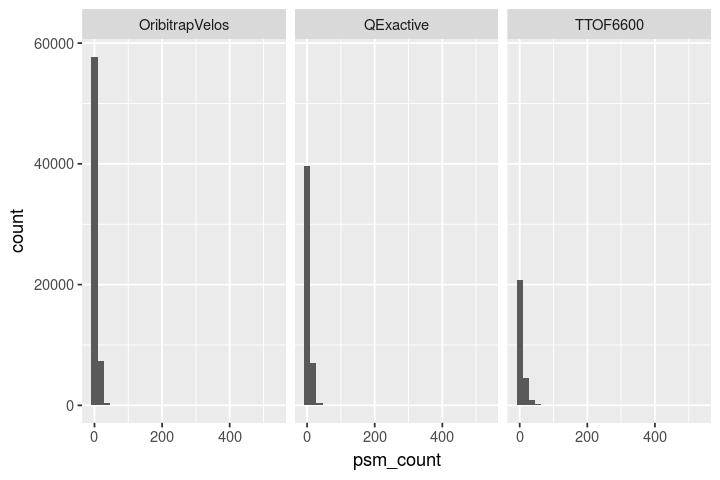

In [14]:
ggplot(seq_count, aes(x = psm_count)) + geom_histogram() + facet_wrap(~source)

In [15]:
Sys.time() - st

Time difference of 3.234904 secs

## 1b) 

In [16]:
st = Sys.time()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


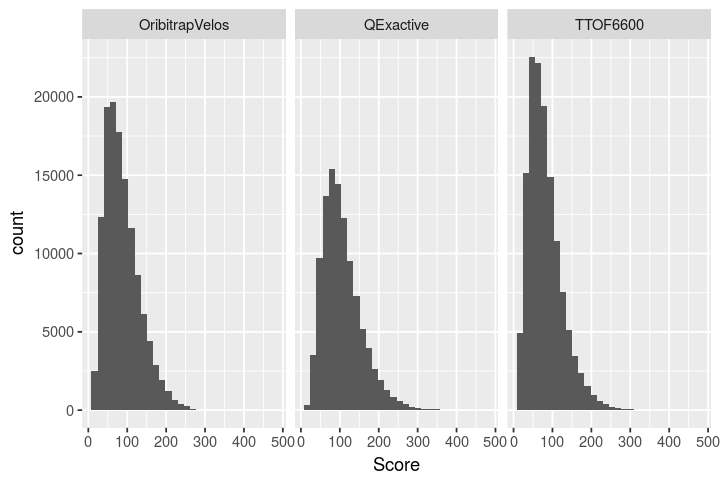

In [17]:
ggplot(data[psm_count > 10,], aes(x = Score)) + geom_histogram() + facet_wrap(~source)

In [18]:
Sys.time() - st

Time difference of 5.884573 secs

b2

In [19]:
st = Sys.time()

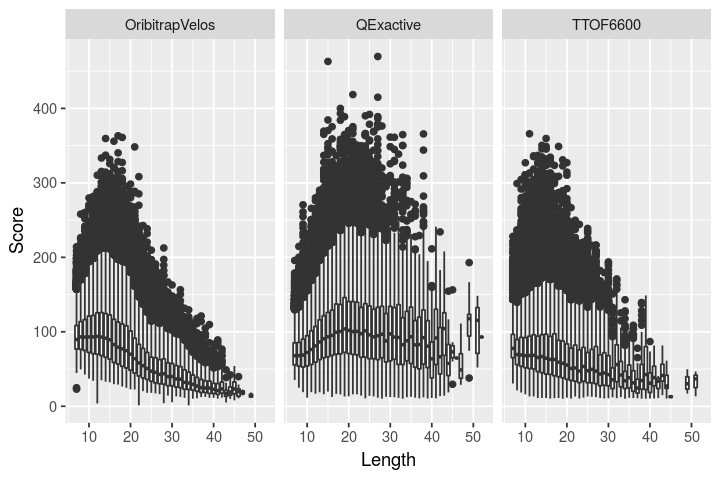

In [20]:
ggplot(data, aes(y = Score, x = Length)) + geom_boxplot(aes(group = Length)) + facet_wrap(~source)

In [21]:
Sys.time() - st

Time difference of 10.51418 secs

b3

In [22]:
st = Sys.time()

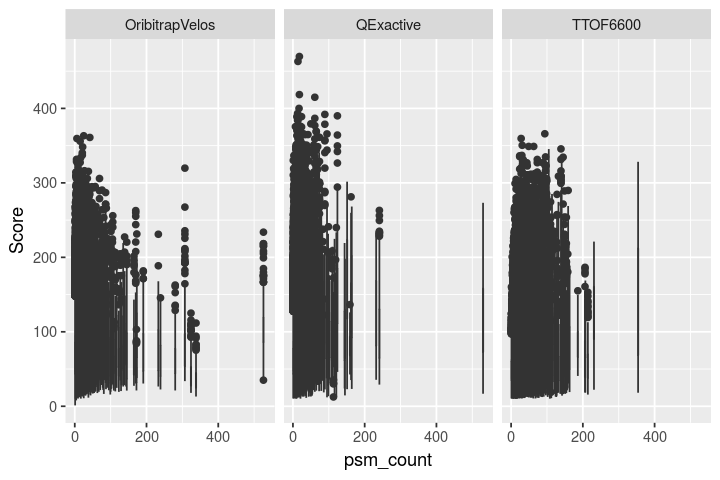

In [23]:
ggplot(data, aes(y = Score, x = psm_count)) + geom_boxplot(aes(group = psm_count)) + facet_wrap(~source)

In [24]:
Sys.time() - st

Time difference of 14.41065 secs

## 1c) 

In [25]:
st = Sys.time()

In [26]:
sum_intensities = Vectorize(function(intensity) {
    str_trim(intensity) %>% str_split(";") %>% extract2(1) %>% as.numeric %>% sum
})

In [27]:
data = data[,intensity := sum_intensities(Intensities)]

In [28]:
Sys.time() - st

Time difference of 11.51801 mins

In [29]:
st = Sys.time()

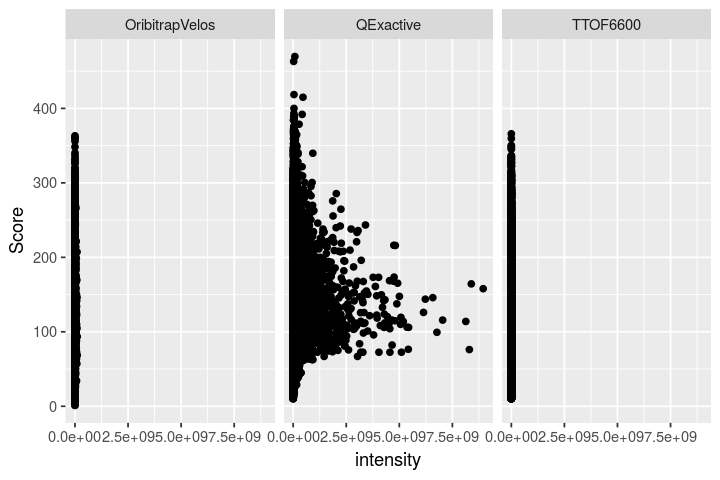

In [30]:
ggplot(data, aes(x = intensity, y = Score)) + geom_point() + facet_wrap(~source)

In [31]:
Sys.time() - st

Time difference of 37.39126 secs

## 1d) plot spectra

In [32]:
st = Sys.time()

In [33]:
split_numeric = Vectorize(function(str_list) {
    str_list %>% str_trim %>% str_split(";") %>% extract2(1) %>% as.numeric
})

In [34]:
spectra = names(sources) %>% map(function (source_name) {
    tmp_dat = data[source == source_name,list(Intensities, Masses)][1]
    tmp_split = data.table(split_numeric(tmp_dat))
    tmp_split[,source := source_name]
}) %>% rbindlist

In [35]:
Sys.time() - st

Time difference of 1.062699 secs

In [36]:
st = Sys.time()

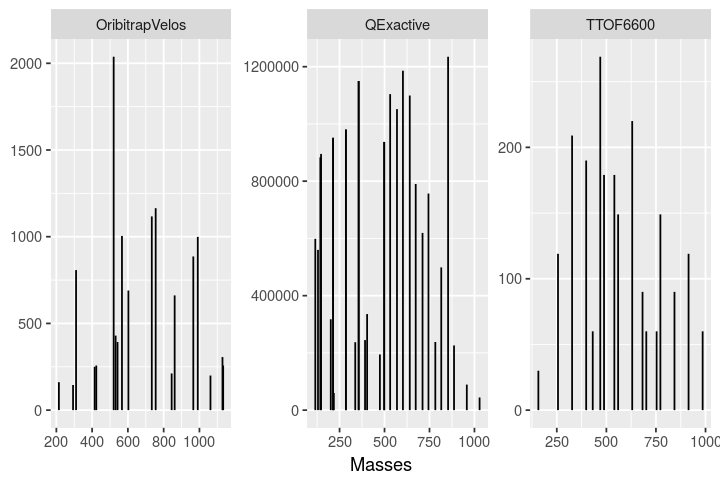

In [37]:
ggplot(spectra, aes(x = Masses, ymin = 0, ymax = Intensities)) + geom_linerange() + facet_wrap(~source, scales="free")

In [38]:
Sys.time() - st

Time difference of 0.5375929 secs

## 1e) 

search all b1-ions

In [39]:
st = Sys.time()

In [40]:
intensities = data[,Intensities] %>% map(split_numeric)

In [41]:
ions = data[,Matches] %>% map(function(x) {
    x %>% str_trim %>% str_split(";") %>% extract2(1) == "b2"
})

In [42]:
my_intensities = data.table(intensity = unlist(intensities)[unlist(ions)])

In [43]:
Sys.time() - st

Time difference of 20.78763 mins

In [44]:
st = Sys.time()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


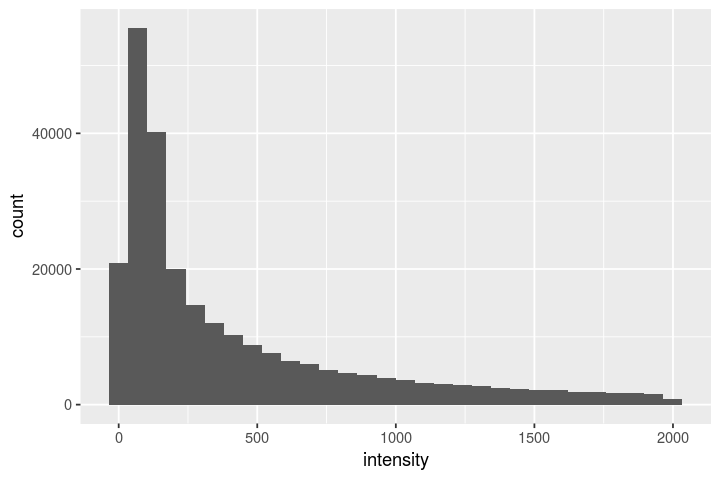

In [45]:
ggplot(my_intensities[intensity < 2000,], aes(x=intensity)) + geom_histogram()

In [46]:
Sys.time() - st

Time difference of 0.6417484 secs